In [3]:
#https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(edgeitems=2, linewidth=75)

In [364]:
# import training data
import  pandas as pd
data = pd.read_csv('../data/co_channel.csv')
data = pd.read_csv('../data/green_channel.csv')

data.head()

,datetime,stage,q,q_sigma
0,2020-05-21 14:13:41 [UTC-07:00],7.04,12199.342,199.172931
1,2020-04-16 14:55:31 [UTC-07:00],4.43,4921.953,95.425619
2,2020-03-04 13:54:10 [UTC-07:00],2.99,2331.665,61.860500
3,2020-03-04 13:16:51 [UTC-07:00],2.94,2289.220,47.886745
4,2020-01-23 11:04:32 [UTC-07:00],2.96,2408.210,99.522964


In [365]:
#observations
t_s = torch.tensor(data['stage']).float().unsqueeze(1)
t_q = torch.tensor(data['q']).float().unsqueeze(1)

#uncertainties
t_q_sigma = torch.tensor(data['q_sigma']).float().unsqueeze(1)
t_s_sigma = torch.tensor([0.01]).float().unsqueeze(1)

t_q.shape

torch.Size([36, 1])

In [366]:
def normalize(t):
    return (t - t.mean())/t.std()

In [367]:
t_s_ln = normalize(t_s.log())
t_q_ln = normalize(t_q.log())

In [368]:
torch.tensor(0.)

tensor(0.)

In [369]:
# TODO fix loss function and forward
class MLP(nn.Module):
    def __init__(self, hidden_layers=[528, 528, 528], droprate=0.2, activation='relu'):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('input', nn.Linear(1, hidden_layers[0]))
        if activation == 'relu':
            self.model.add_module('relu0', nn.ReLU())
        elif activation == 'tanh':
            self.model.add_module('tanh0', nn.Tanh())
        for i in range(len(hidden_layers)-1):
            self.model.add_module('dropout'+str(i+1), nn.Dropout(p=droprate))
            self.model.add_module('hidden'+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            if activation == 'relu':
                self.model.add_module('relu'+str(i+1), nn.ReLU())
            elif activation == 'tanh':
                self.model.add_module('tanh'+str(i+1), nn.Tanh())
        self.model.add_module('dropout'+str(i+2), nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(hidden_layers[i+1], 1))
        
    def forward(self, x):
        # XXX probably need to move transformations here
        return self.model(x)

class Transform():
    # XXX fix
    def __init__(self, x, log=True):
        self.log = log
        
        if self.log:
            x_t = torch.log(x)
        else:
            x_t = x
        
        self.mean = x_t.mean()
        self.std = x_t.std()

    
    def transform(self, x):
        if self.log:
            x_t = torch.log(x)
        else:
            x_t = x
            
        return (x_t - self.mean) / self.std
    
    def untransform(self, x_t):
        #return (torch.exp(x_t) * self.std) + self.mean
        x = x_t * self.std + self.mean
        
        if self.log:
            x = torch.exp(x)
        
        return x
        
    
class MLPRegressor: #Rename RatingModel
    def __init__(self, hidden_layers=[528, 528, 528], droprate=0.2, activation='relu', \
                 max_epoch=10000, lr=0.0001, weight_decay=1e-6):
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = MLP(hidden_layers=hidden_layers, droprate=droprate, activation=activation)
        #self.model.cuda() #check if cuda available
        self.criterion = nn.MSELoss()#.cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        
    def fit(self, x_train, y_train, x_sigma=torch.tensor(0.), y_sigma=torch.tensor(0.), verbose=True, log=True):
        # TODO assert correct dimensions
        # TODO verify noise is working as expected, if not move tranform outside of loop
        # TOOD cuda-fy (#print warning if no GPU found and verbose)
        
        # Setup transformations
        self.x_transform = Transform(x_train, log=log)
        self.y_transform = Transform(y_train, log=log)

        #X = Variable(torch.from_numpy(X_train).type(torch.FloatTensor))#.cuda()
        #y = Variable(torch.from_numpy(y_train).type(torch.FloatTensor))#.cuda()
        print(self.model)
        
        for epoch in range(1,self.max_epoch+1):
            self.optimizer.zero_grad()
            # add measurement uncertainty
            x = self.x_transform.transform(x_train + x_sigma*torch.randn(x_train.shape))
            y = self.y_transform.transform(y_train + y_sigma*torch.randn(y_train.shape)) #set type and send to cuda?
            
            outputs = self.model(x) #XXX TODO verify that this is making a difference
            loss = self.criterion(outputs, y) #XXX verify this too
            loss.backward()
            self.optimizer.step()
            if verbose:
                #if epoch == 3000:
                    #import pdb; pdb.set_trace()
                if epoch == 1 or epoch % 1000 == 0:
                    print('Epoch {} loss: {}'.format(epoch, loss.data))##[0]))
        return self
    
    def predict(self, x, n=1000, on='cpu'):
        # run on cpu by default
        self.model.train() # should I overwrite?
        x_t = self.x_transform.transform(x)
        #y_t_hat = np.array([self.model(x_t).data.cpu().numpy() for _ in range(n)]).squeeze()
        y_t_hat = torch.tensor([self.model(x_t).data.cpu().numpy() for _ in range(n)]).squeeze()
        self.model.eval()
        #y_t_mle = self.model(x_t).data.cpu().numpy()
        y_t_mle = self.model(x_t).data.cpu()
        self.model.train()
        y_hat = self.y_transform.untransform(y_t_hat).numpy() #transform expects tensor, so transform then convert to numpy
        y_mle = self.y_transform.untransform(y_t_mle).numpy()
        return y_hat#, y_mle
        
    def load(self, filename):
        return
    

In [394]:
### Below is training code, uncomment to train your own model... ###
### Note: You need GPU and CUDA to run this section ###
'''
# Define networks
mlp2 = [MLP2Regressor(activation='relu'),
        MLP2Regressor(activation='tanh')]
        
# Training, set verbose=True to see loss after each epoch.
[mlp.fit(X_train, y_train,verbose=False) for mlp in mlp2]

# Save torch models
for ind, mlp in enumerate(mlp2):
    torch.save(mlp.model, 'co2_mlp2_'+str(ind)+'.pth')
'''

#hidden_layers = [528, 256, 256]
#width = 64 #528
width = 528
#mpl2 = MLP2Regressor(hidden_layers=[528,528,528], droprate=0.2, max_epoch=5000, activation='relu')
#mpl2 = MLPRegressor(hidden_layers=[528,528,528,528], droprate=0.2, max_epoch=5000, activation='relu')
mpl2 = MLPRegressor(hidden_layers=[width, width, width], droprate=0.0, max_epoch=5000, activation='relu') #0.1 might be better
mpl2.fit(t_s, t_q,verbose=True, log=False) #XXX move log to regressor

#torch.save(mlp2.model, 'filename')

MLP(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=528, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (hidden1): Linear(in_features=528, out_features=528, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.0, inplace=False)
    (hidden2): Linear(in_features=528, out_features=528, bias=True)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.0, inplace=False)
    (final): Linear(in_features=528, out_features=1, bias=True)
  )
)
Epoch 1 loss: 0.8722246289253235
Epoch 1000 loss: 3.512908733682707e-05
Epoch 2000 loss: 2.8993681553401984e-05
Epoch 3000 loss: 2.661107100720983e-05
Epoch 4000 loss: 2.733432484092191e-05
Epoch 5000 loss: 2.3275602870853618e-05


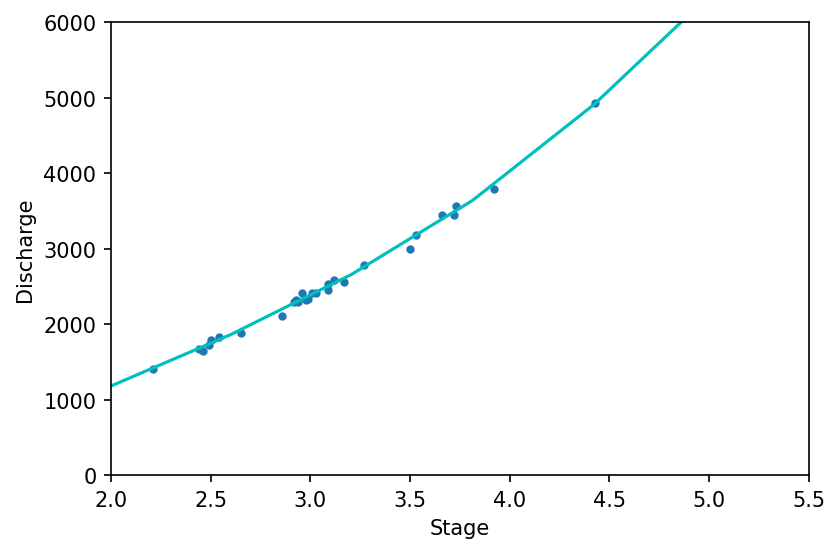

In [397]:
# plot
# colorado river
# interesting higher dropout rates overestimate lower values (0.1 seems to work well)

from matplotlib import pyplot as plt
s_n_range = torch.linspace(t_s.min()*0.9, t_s.max()*1.1, steps=20).unsqueeze(1)

y_hat = mpl2.predict(s_n_range, n=1000)
y = y_hat.mean(axis=0)
y_upper = np.quantile(y_hat, 0.975, axis=0)
y_lower = np.quantile(y_hat, 0.025, axis=0)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")
plt.ylim(0,6000)
plt.xlim(2.0,5.5)

plt.plot(t_s.numpy(), t_q.numpy(), 'o', ms=3)
plt.plot(s_n_range.numpy(), y, 'c-')
plt.fill_between(s_n_range.numpy().flatten(), y1=y_upper, y2=y_lower, alpha=0.5, color='c')
#y_relu_mc_std = y_hat.std(axis=0)

In [ ]:

import  pandas as pd
data = pd.read_csv('../data/co_channel.csv')
t_s = torch.tensor(data['stage']).float().unsqueeze(1)
t_q = torch.tensor(data['q']).float().unsqueeze(1)

#hidden_layers = [528, 256, 256]
# best so far is 528*2 yields 0.002 score
width = 528 #528 seems best
depth = 2
dropout = 0.2
hidden_layers = [width] * depth

#mpl2 = MLP2Regressor(hidden_layers=[528,528,528], droprate=0.2, max_epoch=5000, activation='relu')
mpl2 = MLPRegressor(hidden_layers=hidden_layers, droprate=dropout, max_epoch=5000, activation='relu')
mpl2.fit(t_s, t_q,verbose=True, log=False) #XXX move log to regressor]

In [241]:
stage.max()

20.95

In [360]:
## fake some data
import  pandas as pd
data = pd.read_csv('../data/co_channel.csv')
t_s = torch.tensor(data['stage']).float().unsqueeze(1)
t_q = torch.tensor(data['q']).float().unsqueeze(1)

#hidden_layers = [528, 256, 256]
# best so far is 528*2 yields 0.002 score
width = 528 * 3#528 seems best
depth = 2
dropout = 0.1
hidden_layers = [width] * depth

#mpl2 = MLP2Regressor(hidden_layers=[528,528,528], droprate=0.2, max_epoch=5000, activation='relu')
mpl2 = MLPRegressor(hidden_layers=hidden_layers, droprate=dropout, max_epoch=5000, activation='relu')
mpl2.fit(t_s, t_q,verbose=True, log=True) #XXX move log to regressor


MLP(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=1584, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.1, inplace=False)
    (hidden1): Linear(in_features=1584, out_features=1584, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.1, inplace=False)
    (final): Linear(in_features=1584, out_features=1, bias=True)
  )
)
Epoch 1 loss: 1.0362602472305298
Epoch 1000 loss: 0.003569138003513217
Epoch 2000 loss: 0.001012396882288158
Epoch 3000 loss: 0.0016095826867967844
Epoch 4000 loss: 0.0014751675771549344
Epoch 5000 loss: 0.0008300747722387314


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 1.100e+01, 1.400e+01, 1.600e+01,
        2.600e+01, 4.400e+01, 7.300e+01, 7.500e+01, 1.180e+02, 1.440e+02,
        1.900e+02, 2.590e+02, 3.750e+02, 4.800e+02, 6.990e+02, 9.180e+02,
        1.113e+03, 1.364e+03, 1.405e+03, 1.386e+03, 1.280e+03, 1.132e+03,
        9.400e+02, 8.170e+02, 6.140e+02, 4.400e+02, 3.470e+02, 2.430e+02,
        1.810e+02, 1.040e+02, 6.800e+01, 4.600e+01, 2.700e+01, 1.500e+01,
        4.000e+00, 7.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.176507  , -0.17000054, -0.16349407, -0.15698761, -0.15048115,
        -0.14397469, -0.13746822, -0.13096176, -0.1244553 , -0.11794884,
        -0.11144237, -0.10493591, -0.09842945, -0.09192299, -0.08541653,
        -0.07891007, -0.0724036 , -0.06589714, -0.05939068, -0.05288422,
        -0.04637776, -0.03987129, -0.03336483, -0.02685837, -0.02035191,
        -0.

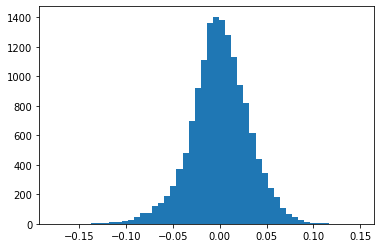

In [361]:
# plot

from matplotlib import pyplot as plt
s_n_range = t_s
y_hat = mpl2.predict(s_n_range, n=1000)
y = y_hat.mean(axis=0)
#y = np.median(y_hat, 0)
#XXX TODO transform to Z scores
error = torch.log(t_q) - np.log(y_hat.T)
out = error.flatten().numpy()
plt.hist(out, bins=50)

In [362]:
error.mean() #-0.0054 for 528x2

tensor(-0.0001)

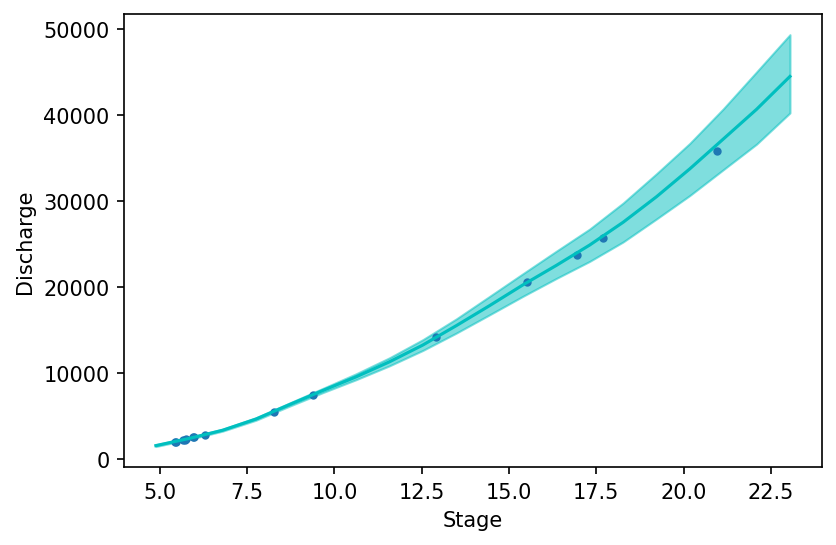

In [363]:
# plot
# colorado river
# 0.1 dropout 528x3x2
from matplotlib import pyplot as plt
s_n_range = torch.linspace(t_s.min()*0.9, t_s.max()*1.1, steps=20).unsqueeze(1)

y_hat = mpl2.predict(s_n_range, n=1000)
y = y_hat.mean(axis=0)
#y = np.median(y_hat, axis=0)
y_upper = np.quantile(y_hat, 0.975, axis=0)
y_lower = np.quantile(y_hat, 0.025, axis=0)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")

#plt.xlim(5,7)
#plt.ylim(0,4000)

plt.plot(t_s.numpy(), t_q.numpy(), 'o', ms=3)
plt.plot(s_n_range.numpy(), y, 'c-')
plt.fill_between(s_n_range.numpy().flatten(), y1=y_upper, y2=y_lower, alpha=0.5, color='c')
#y_relu_mc_std = y_hat.std(axis=0)

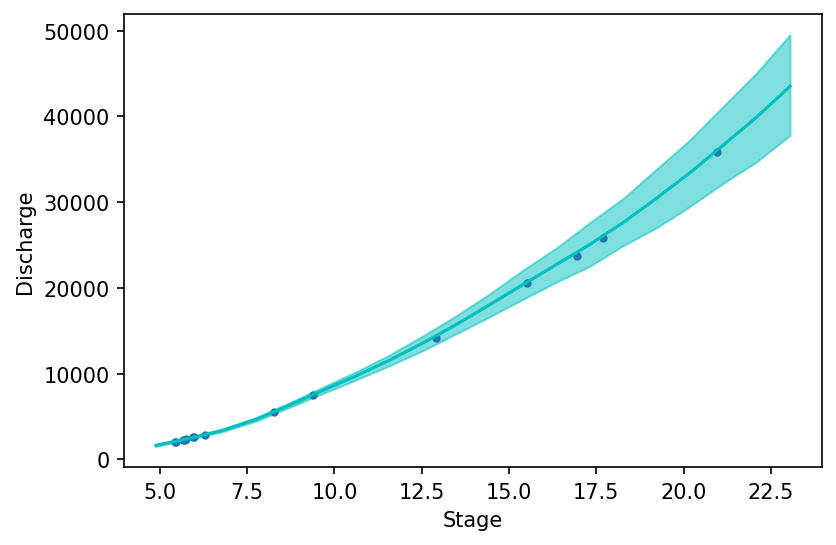

In [343]:
# plot
# colorado river
# 0.1 dropout
from matplotlib import pyplot as plt
s_n_range = torch.linspace(t_s.min()*0.9, t_s.max()*1.1, steps=20).unsqueeze(1)

y_hat = mpl2.predict(s_n_range, n=1000)
y = y_hat.mean(axis=0)
#y = np.median(y_hat, axis=0)
y_upper = np.quantile(y_hat, 0.975, axis=0)
y_lower = np.quantile(y_hat, 0.025, axis=0)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")

#plt.xlim(5,10)
#plt.ylim(0,10000)

plt.plot(t_s.numpy(), t_q.numpy(), 'o', ms=3)
plt.plot(s_n_range.numpy(), y, 'c-')
plt.fill_between(s_n_range.numpy().flatten(), y1=y_upper, y2=y_lower, alpha=0.5, color='c')
#y_relu_mc_std = y_hat.std(axis=0)

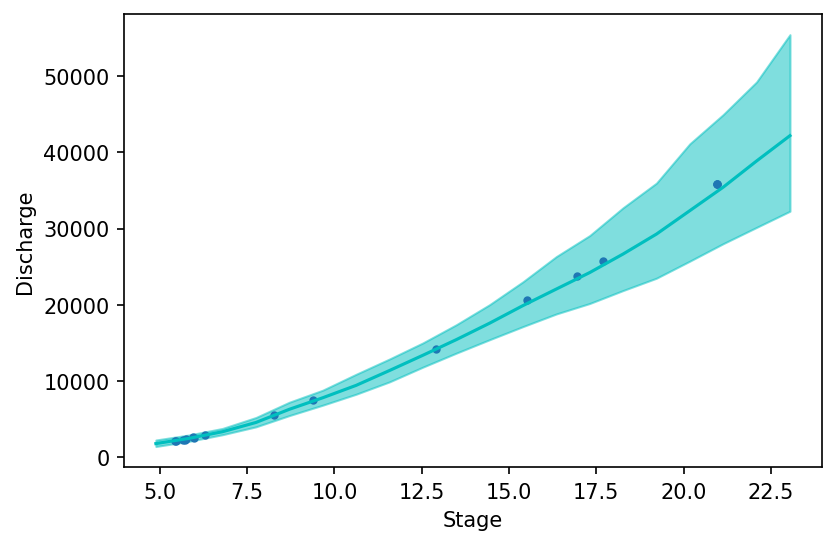

In [292]:
# plot
# colorado river fake
from matplotlib import pyplot as plt
s_n_range = torch.linspace(t_s.min()*0.9, t_s.max()*1.1, steps=20).unsqueeze(1)

y_hat = mpl2.predict(s_n_range, n=1000)
y = y_hat.mean(axis=0)
y_upper = np.quantile(y_hat, 0.975, axis=0)
y_lower = np.quantile(y_hat, 0.025, axis=0)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")

#plt.xlim(5,10)
#plt.ylim(0,10000)
plt.plot(t_s.numpy(), t_q.numpy(), 'o', ms=3)
plt.plot(s_n_range.numpy(), y, 'c-')
plt.fill_between(s_n_range.numpy().flatten(), y1=y_upper, y2=y_lower, alpha=0.5, color='c')
#y_relu_mc_std = y_hat.std(axis=0)

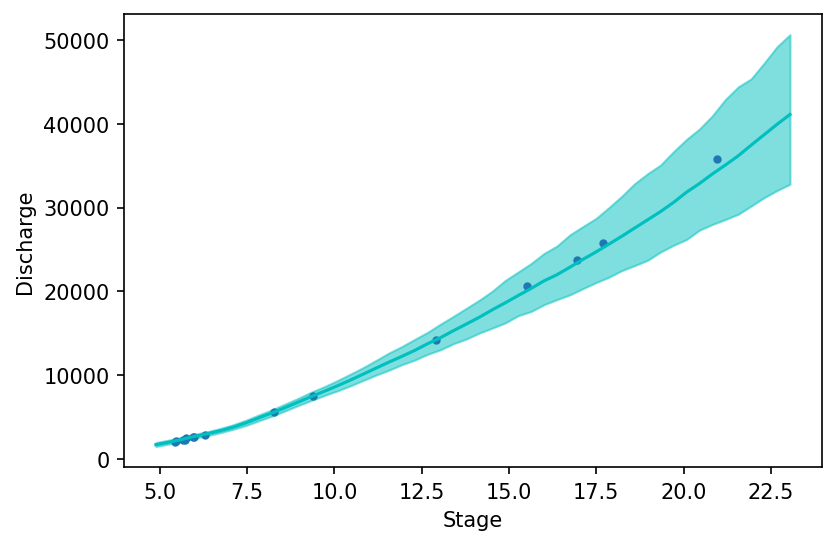

In [174]:
# plot
# green reiver
from matplotlib import pyplot as plt
s_n_range = torch.linspace(t_s.min()*0.9, t_s.max()*1.1, steps=50).unsqueeze(1)

y_hat = mpl2.predict(s_n_range, n=2000)
y = y_hat.mean(axis=0)
y_upper = np.quantile(y_hat, 0.975, axis=0)
y_lower = np.quantile(y_hat, 0.025, axis=0)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")


plt.plot(t_s.numpy(), t_q.numpy(), 'o', ms=3)
plt.plot(s_n_range.numpy(), y, 'c-')
plt.fill_between(s_n_range.numpy().flatten(), y1=y_upper, y2=y_lower, alpha=0.5, color='c')
#y_relu_mc_std = y_hat.std(axis=0)

In [146]:


s_n_range = torch.linspace(t_s_ln.min()*0.9, t_s_ln.max()*1.1, steps=20).unsqueeze(1)
s_n_relu_pred, y_hat = predict_reg(mpl2, s_n_range)
y_mu = y_hat.mean(axis=0)
y_std = y_hat.std(axis=0)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")


plt.plot(t_s_ln.numpy(), t_q_ln.numpy(), 'o')
plt.plot(s_n_range.numpy(), y_mu, 'c-')
plt.fill_between(s_n_range.numpy().flatten(), y1=y_mu + 1.96*y_std, y2=y_mu - 1.96*y_std, alpha=0.5, color='c')
#plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

array([12329.015 ,  4993.4385,  2351.3577,  2295.0469,  2316.6318,
        2489.3545,  1697.4719,  1800.7755,  2177.0637,  3101.916 ,
       20763.828 ,  8240.167 ,  1413.3885,  2593.006 ,  2490.9766,
        1745.3494,  1930.5486,  2344.73  ,  2413.9739, 11079.205 ,
        3801.328 ,  2272.4402,  2262.6296,  3481.9944,  3064.5178,
        3499.2156,  2540.7517,  3349.8096, 18693.09  , 12510.251 ,
        8729.963 ,  2726.037 ,  2390.0684,  1746.8278,  1672.9391,
       30386.836 ], dtype=float32)

In [149]:
np.quantile(y_hat, 0.975, axis=0)

array([13805.77941895,  5298.10837402,  2457.41132202,  2398.14725952,
        2412.6605896 ,  2580.81318359,  1840.11071472,  1930.12709351,
        2309.08330688,  3210.98812866, 24981.15014648,  9283.04909668,
        1561.77999878,  2691.88939209,  2588.52041016,  1872.53797302,
        2064.54838867,  2459.57628174,  2529.86872559, 12418.2579834 ,
        3962.15195923,  2405.98359985,  2372.31858521,  3641.43936768,
        3195.0928894 ,  3680.50001831,  2665.67998657,  3492.81826782,
       22336.69912109, 14175.86547852,  9618.21203613,  2831.75936279,
        2498.38477173,  1858.44941406,  1829.84346619, 38268.34316406])

In [117]:
y

array([11.7325   ,  9.374648 ,  8.65147  ,  8.635521 ,  8.639269 ,
        8.687706 ,  8.490656 ,  8.50947  ,  8.60193  ,  8.852864 ,
       15.1019945, 10.354536 ,  8.425782 ,  8.716981 ,  8.685675 ,
        8.500274 ,  8.53742  ,  8.647137 ,  8.663926 , 11.315566 ,
        9.036872 ,  8.627061 ,  8.626301 ,  8.959358 ,  8.833855 ,
        8.962076 ,  8.696872 ,  8.933007 , 13.995409 , 11.794818 ,
       10.478416 ,  8.747455 ,  8.659281 ,  8.49631  ,  8.484071 ,
       19.167538 ], dtype=float32)

In [109]:
np.exp(y)

array([1.3016149e+05, 1.1654950e+04, 5.7210679e+03, 5.6165903e+03,
       5.6471836e+03, 5.9187280e+03, 4.8682832e+03, 4.9671191e+03,
       5.4510435e+03, 7.0206377e+03, 3.1214400e+06, 3.0856477e+04,
       4.5526108e+03, 6.0833467e+03, 5.9279131e+03, 4.8963506e+03,
       5.0940312e+03, 5.7030264e+03, 5.7920459e+03, 8.4614383e+04,
       8.4348789e+03, 5.5832339e+03, 5.5744341e+03, 7.7915303e+03,
       6.8946431e+03, 7.8348887e+03, 5.9842886e+03, 7.5720386e+03,
       1.3960022e+06, 1.2450694e+05, 3.6865199e+04, 6.2891914e+03,
       5.7482710e+03, 4.8917393e+03, 4.8482168e+03, 2.1885384e+08],
      dtype=float32)

In [104]:
y

array([11.776531 ,  9.363486 ,  8.651911 ,  8.63348  ,  8.638912 ,
        8.685877 ,  8.490497 ,  8.510595 ,  8.603562 ,  8.856609 ,
       14.953805 , 10.337102 ,  8.423456 ,  8.71331  ,  8.6874275,
        8.496245 ,  8.535825 ,  8.648752 ,  8.664241 , 11.34586  ,
        9.040131 ,  8.627523 ,  8.625946 ,  8.960793 ,  8.8385   ,
        8.966342 ,  8.696893 ,  8.932218 , 14.149123 , 11.732117 ,
       10.515023 ,  8.746588 ,  8.656654 ,  8.495303 ,  8.486366 ,
       19.203915 ], dtype=float32)

In [ ]:
# plot



In [83]:
mpl1 = MLPRegressor(hidden_layers=[528,528,528], droprate=0.2, max_epoch=5000, activation='relu')
mpl1.fit(t_s, t_q,verbose=True)

MLP(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=528, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (hidden1): Linear(in_features=528, out_features=528, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (hidden2): Linear(in_features=528, out_features=528, bias=True)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.2, inplace=False)
    (final): Linear(in_features=528, out_features=1, bias=True)
  )
)
Epoch 2 loss: 0.9237725734710693
Epoch 1001 loss: 0.00326955015771091
Epoch 2001 loss: 0.004237708169966936
Epoch 3001 loss: 0.006592483725398779
Epoch 4001 loss: 0.0031828221399337053
Epoch 5001 loss: 0.002376909600570798


In [49]:
mpl2.model.eval?

Signature: mpl2.model.eval() -> ~T
Docstring:
Sets the module in evaluation mode.

This has any effect only on certain modules. See documentations of
particular modules for details of their behaviors in training/evaluation
mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
etc.

This is equivalent with :meth:`self.train(False) <torch.nn.Module.train>`.

See :ref:`locally-disable-grad-doc` for a comparison between
`.eval()` and several similar mechanisms that may be confused with it.

Returns:
    Module: self
File:      c:\users\thodson\appdata\local\programs\python\python39\lib\site-packages\torch\nn\modules\module.py
Type:      method


In [44]:
s_transform = Transform(t_s)

In [45]:
s_transform.transform(t_s)

tensor([[ 1.4826e+00],
        [ 4.0433e-01],
        [-5.1076e-01],
        [-5.5001e-01],
        [-5.3423e-01],
        [-4.3418e-01],
        [-9.6493e-01],
        [-8.9043e-01],
        [-6.1423e-01],
        [-1.2430e-01],
        [ 2.2045e+00],
        [ 9.4155e-01],
        [-1.2144e+00],
        [-3.7469e-01],
        [-4.3418e-01],
        [-9.2738e-01],
        [-7.9175e-01],
        [-5.1856e-01],
        [-4.7983e-01],
        [ 1.3323e+00],
        [ 1.1963e-01],
        [-5.5795e-01],
        [-5.6590e-01],
        [-2.2673e-03],
        [-1.4417e-01],
        [ 3.9817e-03],
        [-4.1169e-01],
        [-4.0117e-02],
        [ 2.0517e+00],
        [ 1.4792e+00],
        [ 9.9923e-01],
        [-3.0239e-01],
        [-4.9524e-01],
        [-9.3671e-01],
        [-9.8393e-01],
        [ 2.7852e+00]])

In [88]:
def predict_reg(model, X, T=1000):
    #X = Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda())
    model = model.model
    model = model.train()
    Yt_hat = np.array([model(X).data.cpu().numpy() for _ in range(T)]).squeeze()
    model = model.eval()
    y_pred = model(X).data.cpu().numpy() #MLE estimate
    model = model.train()
    return y_pred, Yt_hat

In [89]:
y_relu_pred, y_hat = predict_reg(mpl2, t_s_ln)
y_relu_mc = y_hat.mean(axis=0)
y_relu_mc_std = y_hat.std(axis=0)

In [90]:
s_n_range.numpy().flatten()

array([-0.7526815 , -0.50778115, -0.2628808 , -0.01798046,  0.22691989,
        0.47182024,  0.7167206 ,  0.9616209 ,  1.2065213 ,  1.4514216 ,
        1.696322  ,  1.9412223 ,  2.1861227 ,  2.4310231 ,  2.6759233 ,
        2.9208236 ,  3.1657243 ,  3.4106247 ,  3.6555252 ,  3.9004254 ],
      dtype=float32)

In [29]:
from matplotlib import pyplot as plt

s_n_range = torch.linspace(t_s_ln.min()*0.9, t_s_ln.max()*1.1, steps=20).unsqueeze(1)
s_n_relu_pred, y_hat = predict_reg(mpl2, s_n_range)
y_mu = y_hat.mean(axis=0)
y_std = y_hat.std(axis=0)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")


plt.plot(t_s_ln.numpy(), t_q_ln.numpy(), 'o')
plt.plot(s_n_range.numpy(), y_mu, 'c-')
plt.fill_between(s_n_range.numpy().flatten(), y1=y_mu + 1.96*y_std, y2=y_mu - 1.96*y_std, alpha=0.5, color='c')
#plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

NameError: name 'predict_reg' is not defined

In [1]:
#t_s_ln = normalize(t_s.log())
#t_q_ln = normalize(t_q.log())
t_s_ln = normalize(t_s)
t_q_ln = normalize(t_q)

NameError: name 'normalize' is not defined

In [110]:

#hidden_layers = [256, 256, 256]
hidden_layers = [1056, 1056] # loss 0.0028
hidden_layers = [528, 528, 528]
mpl2 = MLP2Regressor(hidden_layers=hidden_layers, droprate=0.2, max_epoch=5000, activation='relu')
mpl2.fit(t_s_ln, t_q_ln,verbose=True)

MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=528, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (hidden1): Linear(in_features=528, out_features=528, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (hidden2): Linear(in_features=528, out_features=528, bias=True)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.2, inplace=False)
    (final): Linear(in_features=528, out_features=1, bias=True)
  )
)
Epoch 1 loss: 1.0849120616912842
Epoch 2 loss: 0.9725840091705322
Epoch 1001 loss: 0.006579444278031588
Epoch 2001 loss: 0.00392288388684392
Epoch 3001 loss: 0.005625448189675808
Epoch 4001 loss: 0.00488757761195302


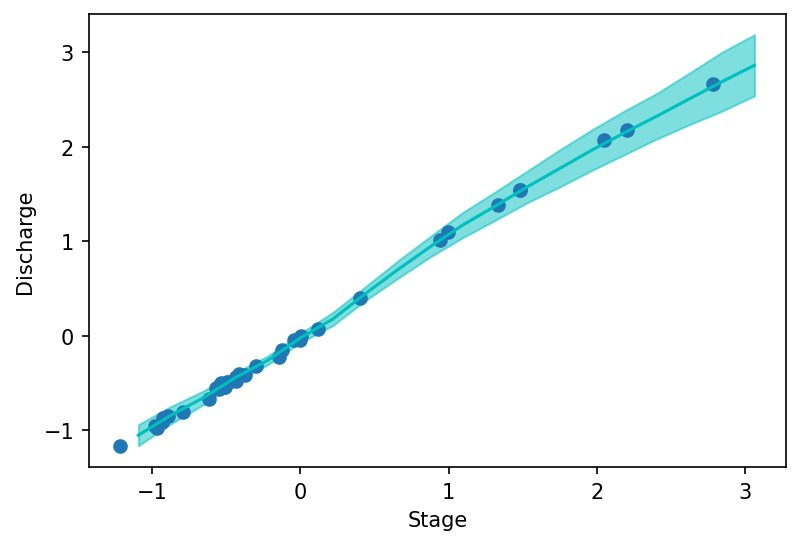

In [111]:
y_relu_pred, y_hat = predict_reg(mpl2, t_s_ln)
y_relu_mc = y_hat.mean(axis=0)
y_relu_mc_std = y_hat.std(axis=0)

from matplotlib import pyplot as plt

s_n_range = torch.linspace(t_s_ln.min()*0.9, t_s_ln.max()*1.1, steps=20).unsqueeze(1)
s_n_relu_pred, y_hat = predict_reg(mpl2, s_n_range)
y_mu = y_hat.mean(axis=0)
y_std = y_hat.std(axis=0)

fig = plt.figure(dpi=150)
plt.xlabel("Stage")
plt.ylabel("Discharge")


plt.plot(t_s_ln.numpy(), t_q_ln.numpy(), 'o')
plt.plot(s_n_range.numpy(), y_mu, 'c-')
plt.fill_between(s_n_range.numpy().flatten(), y1=y_mu + 1.96*y_std, y2=y_mu - 1.96*y_std, alpha=0.5, color='c')
#plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')